In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,50122,None,None,85801.711493
2020-06-13,50123,None,None,79691.325101
2020-06-14,50124,None,None,74024.370787
2020-06-15,50125,None,None,68685.423614
2020-06-16,50126,None,None,63927.452744
...,...,...,...,...
2021-04-19,50433,None,None,25734.144166
2021-04-20,50434,None,None,24565.076256
2021-04-21,50435,None,None,23533.957981


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-23_2021-04-23-19-39.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-21_2021-04-21-18-16.pickle


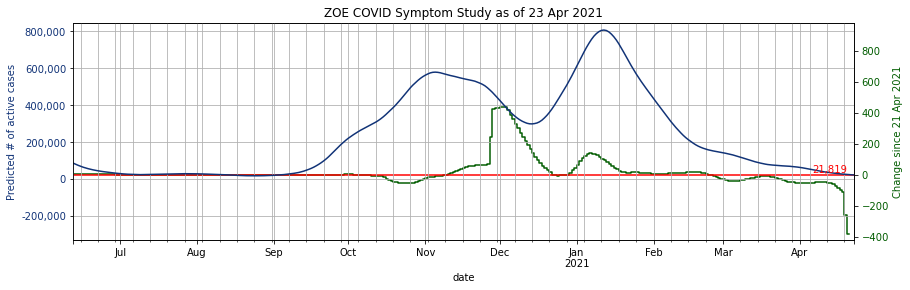

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

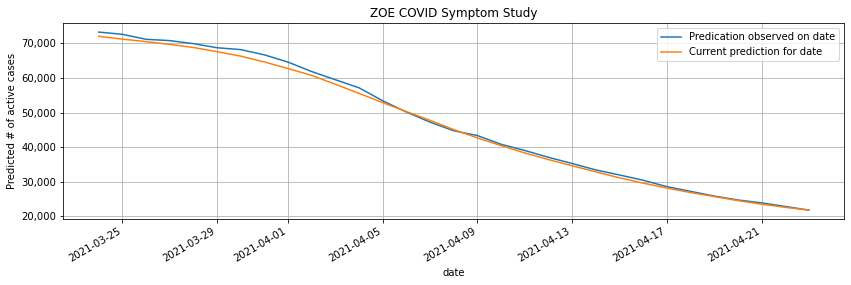

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-23_2021-04-23-19-39.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
15,"Kingston upon Hull, City of",E06000010,0.668877
267,Bury,E08000002,0.459166
247,Nuneaton and Bedworth,E07000219,0.346189
325,Glasgow City,S12000046,0.290313
150,Watford,E07000103,0.244661
260,Coventry,E08000026,0.219574
333,Flintshire,W06000005,0.208151
143,Blaby,E07000129,0.205264
279,Barnsley,E08000016,0.187290
240,Wakefield,E08000036,0.181172
